In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from glob import glob
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/OpenClassrooms/06/"

source_directory_path = base_path + "data/Images/"
target_directory_path = base_path + "ten_breeds_data/"

In [ ]:
selected_breed_directory_names = [
    "n02116738-African_hunting_dog/",
    "n02115913-dhole/",
    "n02115641-dingo/",
    "n02113978-Mexican_hairless/",
    "n02113799-standard_poodle/",
    "n02113186-Cardigan/",
    "n02113023-Pembroke/",
    "n02112706-Brabancon_griffon/",
    "n02112350-keeshond/",
    "n02112137-chow/"
]
num_classes = len(selected_breed_directory_names)

In [ ]:
def get_n_items_per_split(total_n_items, splits=[.6, .2, .2]):
  if sum(splits) != 1:
    return None

  remaining_n_items = total_n_items
  remaining_absolute_share = 1.
  n_items_per_split = []

  for split_absolute_share in splits:

    split_share_relative_to_whats_left = split_absolute_share / remaining_absolute_share
    split_n_items = int(remaining_n_items * split_share_relative_to_whats_left)
    n_items_per_split.append(split_n_items)
    remaining_n_items -= split_n_items
    remaining_absolute_share -= split_absolute_share

  return n_items_per_split

def get_bounds_per_split(total_n_items, splits=[.6, .2, .2]):
  if sum(splits) != 1:
    return None

  n_items_per_split = get_n_items_per_split(total_n_items, splits)

  current_left_bound = 0
  bounds_per_split = []
  for n_items in n_items_per_split:
    left_bound = current_left_bound
    right_bound = left_bound + n_items
    bounds_per_split.append([left_bound, right_bound])
    current_left_bound += n_items

  return bounds_per_split

In [ ]:
def get_file_paths_per_dataset(source_breed_directory_path):
  DATASET_NAMES = ['train', 'val', 'test']
  SPLIT_SIZES = [.6, .2, .2]

  file_paths = glob(source_breed_directory_path + '*.jpg')
  n_files = len(file_paths)
  bounds_per_split = get_bounds_per_split(n_files, splits=SPLIT_SIZES)

  file_paths_per_dataset = {}

  for i, dataset_name in enumerate(DATASET_NAMES):
    left_bound, right_bound = bounds_per_split[i]
    file_paths_per_dataset.update({dataset_name: file_paths[left_bound:right_bound]})

  return file_paths_per_dataset

def get_file_names_per_dataset(file_paths_per_dataset, source_breed_directory_path):
  DATASET_NAMES = ['train', 'val', 'test']

  prefix_length = len(source_breed_directory_path)
  file_names_per_dataset = {}

  for dataset_name in DATASET_NAMES:
    file_names = []
    file_paths = file_paths_per_dataset[dataset_name]
    for file_path in file_paths:
      file_name = file_path[prefix_length:]
      file_names.append(file_name)
    file_names_per_dataset.update({dataset_name: file_names})

  return file_names_per_dataset

def remove_directory_if_exists(path):
  try:
    !rm -rf {path}
  except:
    pass

def build_target_breed_dataset_directory(target_breed_dataset_directory_path, dataset_file_paths, dataset_file_names):
  !mkdir {target_breed_dataset_directory_path}
  # test
  n_files_transferred = 0
  for source_path, name in zip(dataset_file_paths, dataset_file_names):
    target_path = target_breed_dataset_directory_path + name
    !cp {source_path} {target_path}
    # test
    n_files_transferred += 1
  # test
  print(f"breed: {target_breed_dataset_directory_path}. \n n_files_transferred: {n_files_transferred}")

def transfer_breed_data(breed_directory_name, source_directory_path, target_directory_path):

  source_breed_directory_path = source_directory_path + breed_directory_name

  file_paths_per_dataset = get_file_paths_per_dataset(source_breed_directory_path)
  file_names_per_dataset = get_file_names_per_dataset(file_paths_per_dataset, source_breed_directory_path)

  for dataset_name in ['train', 'val', 'test']:

    target_breed_dataset_directory_path = target_directory_path + dataset_name + '/' + breed_directory_name
    dataset_file_paths = file_paths_per_dataset[dataset_name]
    dataset_file_names = file_names_per_dataset[dataset_name]

    remove_directory_if_exists(target_breed_dataset_directory_path)
    build_target_breed_dataset_directory(target_breed_dataset_directory_path, dataset_file_paths, dataset_file_names)


In [ ]:
# Already done

# for breed_directory_name in selected_breed_directory_names:
#   transfer_breed_data(breed_directory_name, source_directory_path, target_directory_path)

In [ ]:
train_ds = image_dataset_from_directory(directory=target_directory_path + 'train/', label_mode='categorical')
val_ds =   image_dataset_from_directory(directory=target_directory_path + 'val/'  , label_mode='categorical')
test_ds =  image_dataset_from_directory(directory=target_directory_path + 'test/' , label_mode='categorical')

Found 975 files belonging to 10 classes.
Found 327 files belonging to 10 classes.
Found 330 files belonging to 10 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.5),
  layers.RandomZoom(height_factor=0.3)
])

model = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(base_path + "models/v_30_model.h5", save_best_only=True)
csv_logger_cb = tf.keras.callbacks.CSVLogger(base_path + "training_logs/v_30_training_log.csv")

In [ ]:
epochs=50
history = model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint_cb, csv_logger_cb]
)

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 3.2778 - accuracy: 0.1046

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 296s 7s/step - loss: 3.2778 - accuracy: 0.1046 - val_loss: 2.2789 - val_accuracy: 0.1437
Epoch 2/50
31/31 [==============================] - 6s 174ms/step - loss: 2.2655 - accuracy: 0.1477 - val_loss: 2.2323 - val_accuracy: 0.1346
Epoch 3/50
31/31 [==============================] - 8s 211ms/step - loss: 2.2355 - accuracy: 0.1631 - val_loss: 2.1939 - val_accuracy: 0.1835
Epoch 4/50
31/31 [==============================] - 6s 168ms/step - loss: 2.1795 - accuracy: 0.1969 - val_loss: 2.1685 - val_accuracy: 0.1621
Epoch 5/50
31/31 [==============================] - 7s 209ms/step - loss: 2.1644 - accuracy: 0.1703 - val_loss: 2.1101 - val_accuracy: 0.1774
Epoch 6/50
31/31 [==============================] - 6s 163ms/step - loss: 2.1477 - accuracy: 0.2041 - val_loss: 2.2308 - val_accuracy: 0.1284
Epoch 7/50
31/31 [==============================] - 6s 162ms/step - loss: 2.1875 - accuracy: 0.1590 - val_loss: 2.1258 - val_accuracy: 0.1957
Epoch 8/50
31/31 [

In [ ]:
loss, acc = model.evaluate(test_ds)

11/11 [==============================] - 61s 909ms/step - loss: 1.8308 - accuracy: 0.3364


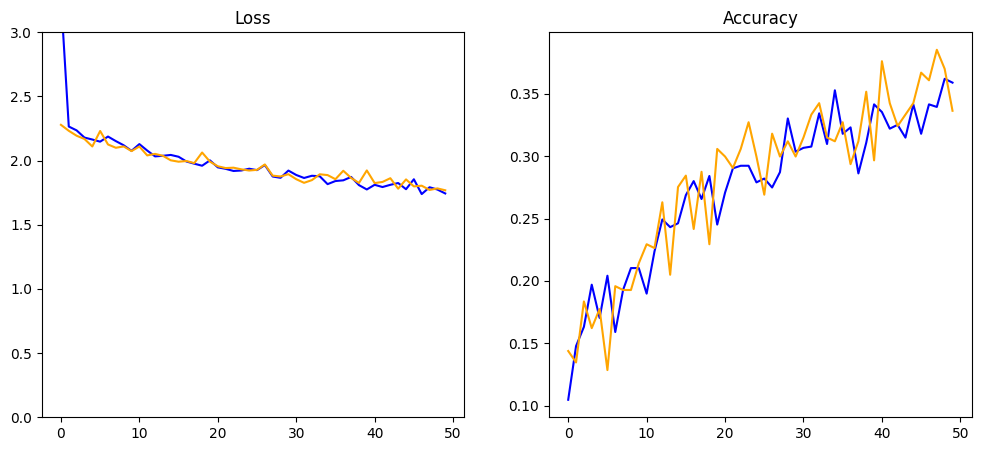

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.set_title('Loss')
ax.set_ylim([0, 3])

plot_data = history.history['loss']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history.history['val_loss']
ax.plot(range(len(plot_data)), plot_data, color='orange')

ax = axes[1]
ax.set_title('Accuracy')

plot_data = history.history['accuracy']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history.history['val_accuracy']
ax.plot(range(len(plot_data)), plot_data, color='orange')

plt.show();

In [ ]:
epochs=50
history_2 = model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint(base_path + "models/v_30_model.h5", save_best_only=True),
      tf.keras.callbacks.CSVLogger(base_path + "training_logs/v_30_training_log_2.csv")
  ]
)

Epoch 1/50
31/31 [==============================] - 8s 221ms/step - loss: 1.7957 - accuracy: 0.3528 - val_loss: 1.8596 - val_accuracy: 0.3394
Epoch 2/50
31/31 [==============================] - 6s 163ms/step - loss: 1.7620 - accuracy: 0.3641 - val_loss: 1.7634 - val_accuracy: 0.3700
Epoch 3/50
31/31 [==============================] - 7s 207ms/step - loss: 1.7579 - accuracy: 0.3497 - val_loss: 1.8003 - val_accuracy: 0.3242
Epoch 4/50
31/31 [==============================] - 6s 155ms/step - loss: 1.7271 - accuracy: 0.3631 - val_loss: 1.8194 - val_accuracy: 0.3486
Epoch 5/50
31/31 [==============================] - 8s 231ms/step - loss: 1.7497 - accuracy: 0.3538 - val_loss: 1.7514 - val_accuracy: 0.3731
Epoch 6/50
31/31 [==============================] - 6s 160ms/step - loss: 1.7663 - accuracy: 0.3569 - val_loss: 1.7804 - val_accuracy: 0.3517
Epoch 7/50
31/31 [==============================] - 6s 156ms/step - loss: 1.7192 - accuracy: 0.3662 - val_loss: 1.7761 - val_accuracy: 0.3517
Epoch 

In [ ]:
loss_2, acc_2 = model.evaluate(test_ds)

11/11 [==============================] - 2s 40ms/step - loss: 1.7860 - accuracy: 0.3970


In [ ]:
history_1_2 = {
    'loss': history.history['loss'] + history_2.history['loss'],
    'val_loss': history.history['val_loss'] + history_2.history['val_loss'],
    'accuracy': history.history['accuracy'] + history_2.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_2.history['val_accuracy']
}

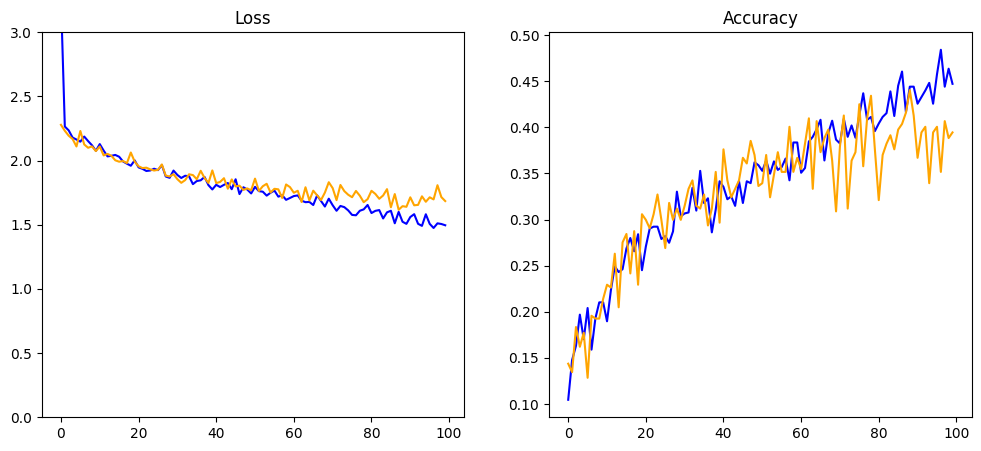

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.set_title('Loss')
ax.set_ylim([0, 3])

plot_data = history_1_2['loss']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_2['val_loss']
ax.plot(range(len(plot_data)), plot_data, color='orange')

ax = axes[1]
ax.set_title('Accuracy')

plot_data = history_1_2['accuracy']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_2['val_accuracy']
ax.plot(range(len(plot_data)), plot_data, color='orange')

plt.show();

In [ ]:
epochs=100
history_3 = model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint(base_path + "models/v_30_model.h5", save_best_only=True),
      tf.keras.callbacks.CSVLogger(base_path + "training_logs/v_30_training_log_3.csv")
  ]
)

Epoch 1/100
31/31 [==============================] - 8s 232ms/step - loss: 1.4681 - accuracy: 0.4779 - val_loss: 1.7363 - val_accuracy: 0.3761
Epoch 2/100
31/31 [==============================] - 6s 163ms/step - loss: 1.4865 - accuracy: 0.4646 - val_loss: 1.6792 - val_accuracy: 0.4281
Epoch 3/100
31/31 [==============================] - 7s 191ms/step - loss: 1.4876 - accuracy: 0.4503 - val_loss: 1.6691 - val_accuracy: 0.3853
Epoch 4/100
31/31 [==============================] - 7s 198ms/step - loss: 1.4617 - accuracy: 0.4738 - val_loss: 1.6855 - val_accuracy: 0.3700
Epoch 5/100
31/31 [==============================] - 6s 158ms/step - loss: 1.4200 - accuracy: 0.4790 - val_loss: 1.7154 - val_accuracy: 0.4098
Epoch 6/100
31/31 [==============================] - 6s 159ms/step - loss: 1.4332 - accuracy: 0.4790 - val_loss: 1.7780 - val_accuracy: 0.4006
Epoch 7/100
31/31 [==============================] - 6s 157ms/step - loss: 1.4025 - accuracy: 0.5026 - val_loss: 1.7252 - val_accuracy: 0.4006

In [ ]:
loss_3, acc_3 = model.evaluate(test_ds)

11/11 [==============================] - 1s 44ms/step - loss: 1.8336 - accuracy: 0.4788


In [ ]:
history_1_3 = {
    'loss': history_1_2['loss'] + history_3.history['loss'],
    'val_loss': history_1_2['val_loss'] + history_3.history['val_loss'],
    'accuracy': history_1_2['accuracy'] + history_3.history['accuracy'],
    'val_accuracy': history_1_2['val_accuracy'] + history_3.history['val_accuracy']
}

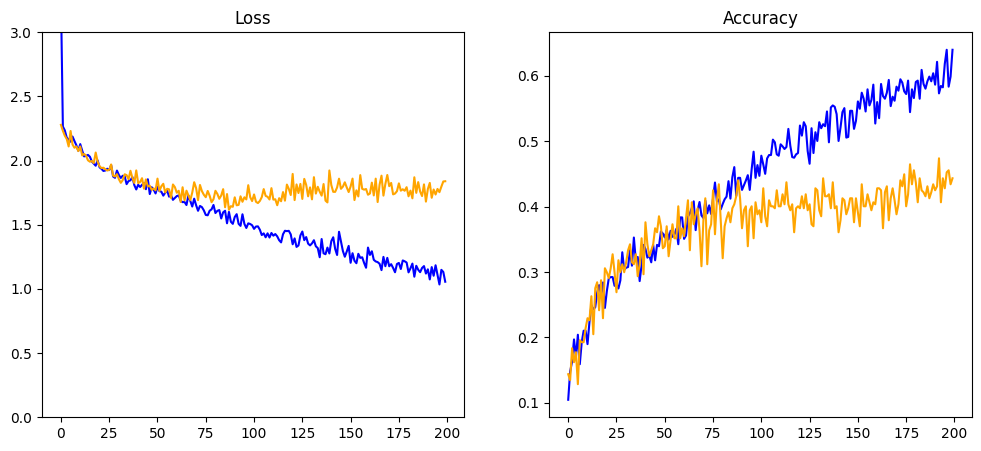

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.set_title('Loss')
ax.set_ylim([0, 3])

plot_data = history_1_3['loss']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_3['val_loss']
ax.plot(range(len(plot_data)), plot_data, color='orange')

ax = axes[1]
ax.set_title('Accuracy')

plot_data = history_1_3['accuracy']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_3['val_accuracy']
ax.plot(range(len(plot_data)), plot_data, color='orange')

plt.show();

In [ ]:
epochs=100
history_4 = model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint(base_path + "models/v_30_model.h5", save_best_only=True),
      tf.keras.callbacks.CSVLogger(base_path + "training_logs/v_30_training_log_4.csv")
  ]
)

Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 1.0242 - accuracy: 0.6271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 11s 279ms/step - loss: 1.0215 - accuracy: 0.6277 - val_loss: 1.9203 - val_accuracy: 0.4312
Epoch 2/100
31/31 [==============================] - 19s 562ms/step - loss: 1.1494 - accuracy: 0.5815 - val_loss: 1.8442 - val_accuracy: 0.4281
Epoch 3/100
31/31 [==============================] - 8s 198ms/step - loss: 1.1144 - accuracy: 0.6072 - val_loss: 1.8350 - val_accuracy: 0.4251
Epoch 4/100
31/31 [==============================] - 9s 273ms/step - loss: 1.0767 - accuracy: 0.6400 - val_loss: 1.7680 - val_accuracy: 0.4373
Epoch 5/100
31/31 [==============================] - 6s 160ms/step - loss: 1.0196 - accuracy: 0.6369 - val_loss: 1.9069 - val_accuracy: 0.4557
Epoch 6/100
31/31 [==============================] - 7s 201ms/step - loss: 1.0949 - accuracy: 0.6369 - val_loss: 1.8059 - val_accuracy: 0.4618
Epoch 7/100
31/31 [==============================] - 6s 159ms/step - loss: 0.9989 - accuracy: 0.6441 - val_loss: 1.8743 - val_accuracy: 0.4343
Epoch 8/1

In [ ]:
loss_4, acc_4 = model.evaluate(test_ds)

11/11 [==============================] - 1s 45ms/step - loss: 1.8917 - accuracy: 0.4939


In [ ]:
history_1_4 = {
    'loss': history_1_3['loss'] + history_4.history['loss'],
    'val_loss': history_1_3['val_loss'] + history_4.history['val_loss'],
    'accuracy': history_1_3['accuracy'] + history_4.history['accuracy'],
    'val_accuracy': history_1_3['val_accuracy'] + history_4.history['val_accuracy']
}

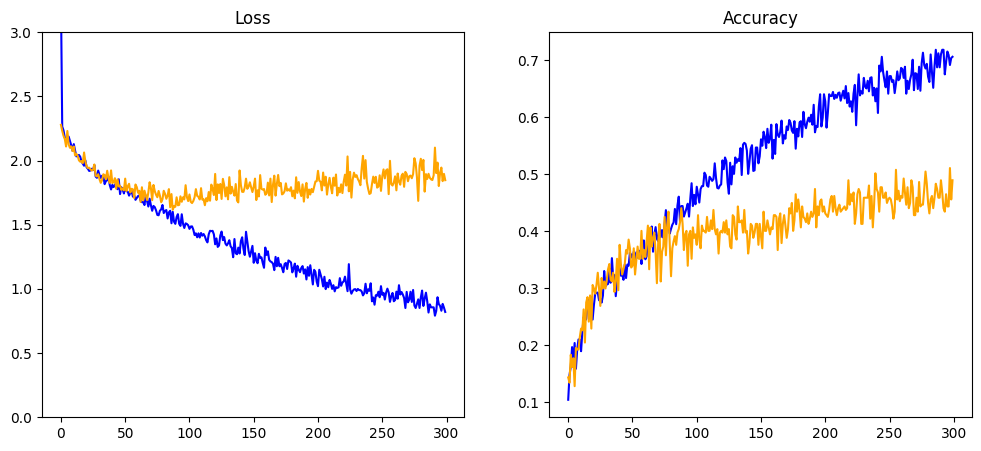

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.set_title('Loss')
ax.set_ylim([0, 3])

plot_data = history_1_4['loss']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_4['val_loss']
ax.plot(range(len(plot_data)), plot_data, color='orange')

ax = axes[1]
ax.set_title('Accuracy')

plot_data = history_1_4['accuracy']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_4['val_accuracy']
ax.plot(range(len(plot_data)), plot_data, color='orange')

plt.show();

In [ ]:
epochs=100
history_5 = model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[
      tf.keras.callbacks.ModelCheckpoint(base_path + "models/v_30_model.h5", save_best_only=True),
      tf.keras.callbacks.CSVLogger(base_path + "training_logs/v_30_training_log_5.csv")
  ]
)

Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.9372 - accuracy: 0.6698

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 10s 261ms/step - loss: 0.9410 - accuracy: 0.6667 - val_loss: 1.8898 - val_accuracy: 0.4587
Epoch 2/100
31/31 [==============================] - 11s 332ms/step - loss: 0.9548 - accuracy: 0.6636 - val_loss: 1.7651 - val_accuracy: 0.5199
Epoch 3/100
31/31 [==============================] - 8s 221ms/step - loss: 0.8224 - accuracy: 0.7015 - val_loss: 1.8711 - val_accuracy: 0.4557
Epoch 4/100
31/31 [==============================] - 8s 176ms/step - loss: 0.8142 - accuracy: 0.7046 - val_loss: 2.0198 - val_accuracy: 0.4862
Epoch 5/100
31/31 [==============================] - 7s 215ms/step - loss: 0.8451 - accuracy: 0.7046 - val_loss: 1.8767 - val_accuracy: 0.4495
Epoch 6/100
31/31 [==============================] - 6s 161ms/step - loss: 0.8638 - accuracy: 0.7026 - val_loss: 1.7962 - val_accuracy: 0.4954
Epoch 7/100
31/31 [==============================] - 7s 178ms/step - loss: 0.7995 - accuracy: 0.7138 - val_loss: 1.8550 - val_accuracy: 0.5168
Epoch 8/1

In [ ]:
loss_5, acc_5 = model.evaluate(test_ds)

11/11 [==============================] - 1s 44ms/step - loss: 1.9382 - accuracy: 0.4636


In [ ]:
history_1_5 = {
    'loss': history_1_4['loss'] + history_5.history['loss'],
    'val_loss': history_1_4['val_loss'] + history_5.history['val_loss'],
    'accuracy': history_1_4['accuracy'] + history_5.history['accuracy'],
    'val_accuracy': history_1_4['val_accuracy'] + history_5.history['val_accuracy']
}

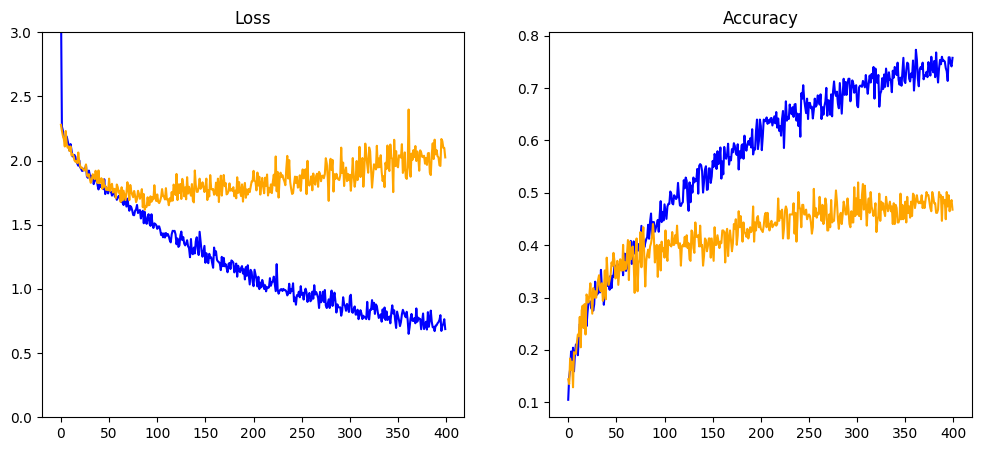

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.set_title('Loss')
ax.set_ylim([0, 3])

plot_data = history_1_5['loss']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_5['val_loss']
ax.plot(range(len(plot_data)), plot_data, color='orange')

ax = axes[1]
ax.set_title('Accuracy')

plot_data = history_1_5['accuracy']
ax.plot(range(len(plot_data)), plot_data, color='blue')

plot_data = history_1_5['val_accuracy']
ax.plot(range(len(plot_data)), plot_data, color='orange')

plt.show();